In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e7/sample_submission.csv
/kaggle/input/playground-series-s5e7/train.csv
/kaggle/input/playground-series-s5e7/test.csv


In [2]:
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

# CatBoost 
from catboost import CatBoostClassifier, Pool

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Example: Adjust file paths to your dataset
train = pd.read_csv('/kaggle/input/playground-series-s5e7/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s5e7/test.csv')

# Preview
train.head()

,id,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
0,0,0.0,No,6.0,4.0,No,15.0,5.0,Extrovert
1,1,1.0,No,7.0,3.0,No,10.0,8.0,Extrovert
2,2,6.0,Yes,1.0,0.0,NaN,3.0,0.0,Introvert
3,3,3.0,No,7.0,3.0,No,11.0,5.0,Extrovert
4,4,1.0,No,4.0,4.0,No,13.0,NaN,Extrovert


In [4]:
train.columns

Index(['id', 'Time_spent_Alone', 'Stage_fear', 'Social_event_attendance',
       'Going_outside', 'Drained_after_socializing', 'Friends_circle_size',
       'Post_frequency', 'Personality'],
      dtype='object')

In [5]:
train.isnull().sum()

id                              0
Time_spent_Alone             1190
Stage_fear                   1893
Social_event_attendance      1180
Going_outside                1466
Drained_after_socializing    1149
Friends_circle_size          1054
Post_frequency               1264
Personality                     0
dtype: int64

In [6]:
test.isnull().sum()

id                             0
Time_spent_Alone             425
Stage_fear                   598
Social_event_attendance      397
Going_outside                466
Drained_after_socializing    432
Friends_circle_size          350
Post_frequency               408
dtype: int64

In [7]:
# Numerical columns to impute with MEDIAN
numerical_cols_to_impute = [
    'Time_spent_Alone', 
    'Social_event_attendance',
    'Going_outside',
    'Friends_circle_size',
    'Post_frequency'
]

# Categorical columns to impute with MODE (Yes/No type)
categorical_cols_to_impute = [
    'Stage_fear', 
    'Drained_after_socializing'
]


In [8]:
# Impute numerical features with median (robust to outliers)
for col in numerical_cols_to_impute:
    median_value = train[col].median()
    train[col].fillna(median_value, inplace=True)
    test[col].fillna(median_value, inplace=True)


In [9]:
# Impute categorical features with mode (most frequent value)
for col in categorical_cols_to_impute:
    mode_value = train[col].mode()[0]
    train[col].fillna(mode_value, inplace=True)
    test[col].fillna(mode_value, inplace=True)

In [10]:
# Define target variable
target = 'Personality'

# Features (drop target and id)
X = train.drop(columns=[target, 'id'])
y = train[target]

# Test features (drop id)
X_test = test.drop(columns=['id'])

In [11]:
# Split train data into training and validation sets (80% train, 20% validation)
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [12]:
# Identify columns with object (string) data type as categorical features
categorical_features = X.select_dtypes(include=['object']).columns.tolist()
print("Categorical features:", categorical_features)

Categorical features: ['Stage_fear', 'Drained_after_socializing']


In [13]:
# Initialize CatBoost Classifier
model = CatBoostClassifier(
    iterations=1000,           # Number of trees
    learning_rate=0.05,        # Step size shrinkage
    depth=6,                    # Tree depth
    eval_metric='Accuracy',     # Use accuracy for evaluation
    cat_features=categorical_features, # Specify categorical columns
    verbose=100,                # Print progress every 100 iterations
    random_seed=42,             # For reproducibility
    early_stopping_rounds=50    # Stop if no improvement after 50 rounds
)

# Train the model
model.fit(X_train, y_train, eval_set=(X_valid, y_valid))


0:	learn: 0.9667994	test: 0.9700405	best: 0.9700405 (0)	total: 59.9ms	remaining: 59.8s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.971120108
bestIteration = 8

Shrink model to first 9 iterations.


In [14]:
# Predict on validation data
y_pred = model.predict(X_valid)

In [15]:
# Calculate accuracy
acc = accuracy_score(y_valid, y_pred)
print("Validation Accuracy:", round(acc, 4))

Validation Accuracy: 0.9711


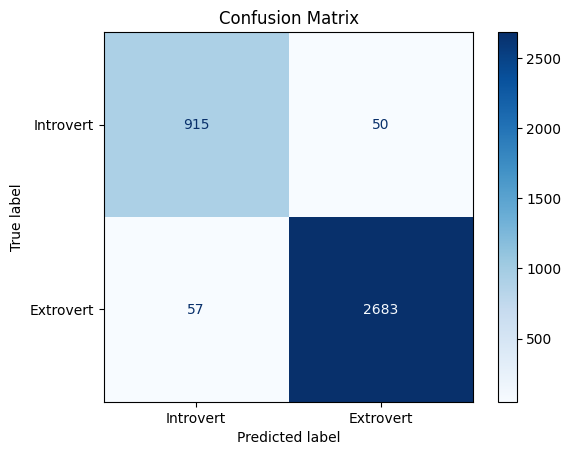

In [16]:
# Create confusion matrix
cm = confusion_matrix(y_valid, y_pred, labels=['Introvert', 'Extrovert'])

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Introvert', 'Extrovert'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [17]:
# Print precision, recall, F1-score
print("Classification Report:\n")
print(classification_report(y_valid, y_pred))

Classification Report:

              precision    recall  f1-score   support

   Extrovert       0.98      0.98      0.98      2740
   Introvert       0.94      0.95      0.94       965

    accuracy                           0.97      3705
   macro avg       0.96      0.96      0.96      3705
weighted avg       0.97      0.97      0.97      3705



In [18]:
# Predict on test set
test_pred = model.predict(X_test)

# Create submission DataFrame
submission = pd.DataFrame({
    'id': test['id'],
    'Personality': test_pred
})

# Save to CSV
submission.to_csv('submission.csv', index=False)
print("Submission file created successfully!")

Submission file created successfully!


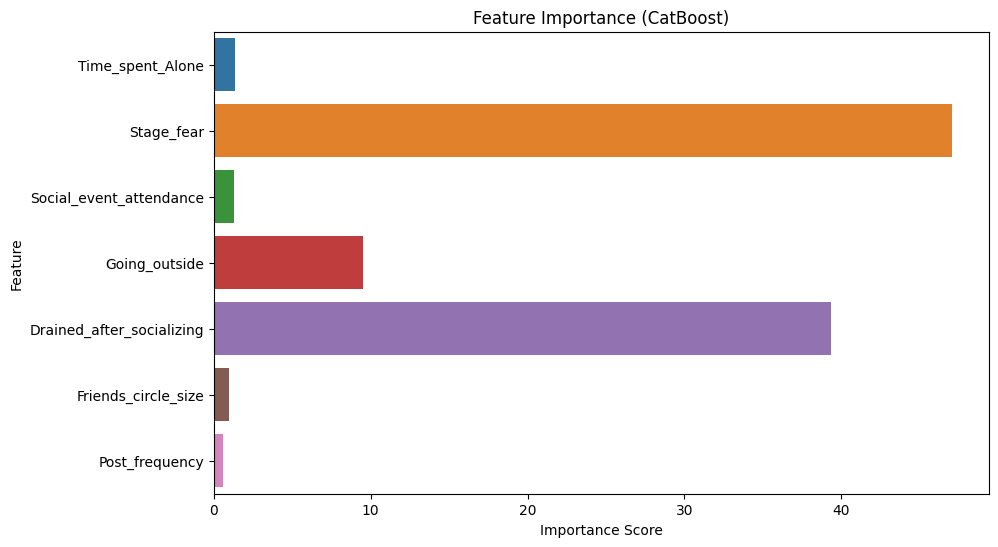

In [19]:
# Get feature importances
feature_importances = model.get_feature_importance()
features = X.columns

# Plot
plt.figure(figsize=(10,6))
sns.barplot(x=feature_importances, y=features)
plt.title('Feature Importance (CatBoost)')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()


In [20]:
import optuna
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

In [21]:
def objective(trial):
    # Suggest hyperparameters to tune
    param = {
        'iterations': trial.suggest_int('iterations', 200, 1000),           # Number of boosting rounds
        'depth': trial.suggest_int('depth', 4, 10),                        # Tree depth
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),  # Step size shrinkage
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),          # L2 regularization
        'random_seed': 42,
        'eval_metric': 'Accuracy',
        'early_stopping_rounds': 50,
        'verbose': 0,
    }

    # Convert categorical feature names to indices (CatBoost requirement)
    cat_features_idx = [X_train.columns.get_loc(c) for c in categorical_features]

    # Use Stratified K-Fold to maintain class distribution across folds
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    accuracies = []

    # Cross-validation loop
    for train_idx, val_idx in skf.split(X_train, y_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        # Initialize CatBoost with current trial parameters
        model = CatBoostClassifier(**param, cat_features=cat_features_idx)
        
        # Train model with early stopping
        model.fit(X_tr, y_tr, eval_set=(X_val, y_val), verbose=0, use_best_model=True)
        
        # Predict and evaluate accuracy
        preds = model.predict(X_val)
        acc = accuracy_score(y_val, preds)
        accuracies.append(acc)

    # Return average accuracy across folds (maximize this)
    return np.mean(accuracies)


In [22]:
import warnings
warnings.filterwarnings('ignore')

In [23]:
# Create a study object that maximizes accuracy
study = optuna.create_study(direction='maximize')

# Run the optimization over a set number of trials (e.g., 30)
study.optimize(objective, n_trials=30)

[I 2025-07-30 11:27:45,368] A new study created in memory with name: no-name-addfa072-2f28-47ba-aaf8-fe68974bb30f
[I 2025-07-30 11:27:46,552] Trial 0 finished with value: 0.9682840369102238 and parameters: {'iterations': 508, 'depth': 6, 'learning_rate': 0.01934329976406353, 'l2_leaf_reg': 9.219136702524267}. Best is trial 0 with value: 0.9682840369102238.
[I 2025-07-30 11:27:47,521] Trial 1 finished with value: 0.9683515269554421 and parameters: {'iterations': 383, 'depth': 5, 'learning_rate': 0.023072922265361718, 'l2_leaf_reg': 8.328636802210696}. Best is trial 1 with value: 0.9683515269554421.
[I 2025-07-30 11:27:48,760] Trial 2 finished with value: 0.9683515132934897 and parameters: {'iterations': 858, 'depth': 9, 'learning_rate': 0.07613575937406382, 'l2_leaf_reg': 2.370650756707281}. Best is trial 1 with value: 0.9683515269554421.
[I 2025-07-30 11:27:49,745] Trial 3 finished with value: 0.9683515269554421 and parameters: {'iterations': 974, 'depth': 5, 'learning_rate': 0.1946812

In [24]:
print("Best trial:")
trial = study.best_trial
print(f"  Accuracy: {trial.value:.4f}")
print("  Params:")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

Best trial:
  Accuracy: 0.9686
  Params:
    iterations: 589
    depth: 8
    learning_rate: 0.1829002098622523
    l2_leaf_reg: 5.252942836971145


In [25]:
# Update best params with fixed parameters
best_params = trial.params
best_params.update({
    'random_seed': 42,
    'eval_metric': 'Accuracy',
    'early_stopping_rounds': 50,
    'verbose': 100,
})

# Convert categorical features to indices again
cat_features_idx = [X_train.columns.get_loc(c) for c in categorical_features]

# Initialize and train the final model
final_model = CatBoostClassifier(**best_params, cat_features=cat_features_idx)
final_model.fit(X_train, y_train, eval_set=(X_valid, y_valid))


0:	learn: 0.9667994	test: 0.9700405	best: 0.9700405 (0)	total: 4.24ms	remaining: 2.49s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.971659919
bestIteration = 44

Shrink model to first 45 iterations.


Validation Accuracy (final model): 0.97165991902834


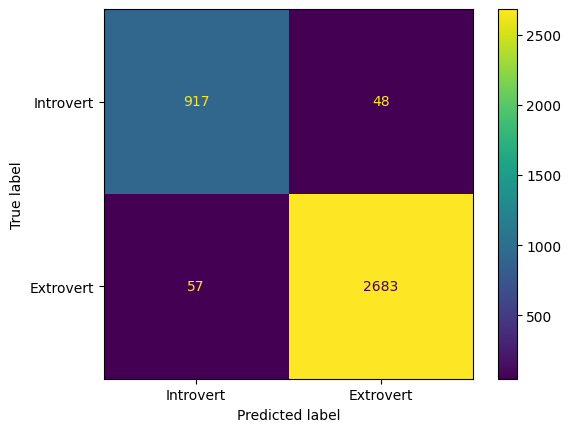

              precision    recall  f1-score   support

   Extrovert       0.98      0.98      0.98      2740
   Introvert       0.94      0.95      0.95       965

    accuracy                           0.97      3705
   macro avg       0.96      0.96      0.96      3705
weighted avg       0.97      0.97      0.97      3705



In [26]:
y_pred = final_model.predict(X_valid)
print("Validation Accuracy (final model):", accuracy_score(y_valid, y_pred))

cm = confusion_matrix(y_valid, y_pred, labels=['Introvert', 'Extrovert'])
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Introvert', 'Extrovert']).plot()
plt.show()

print(classification_report(y_valid, y_pred))


In [27]:
test_pred = final_model.predict(X_test)
submission = pd.DataFrame({'id': test['id'], 'Personality': test_pred})
submission.to_csv('submission.csv', index=False)
print("Final submission saved!")


Final submission saved!
